In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torchvision import transforms

import h5py

from tqdm import tqdm

In [2]:
device = torch.device('cuda')

## Data

In [3]:
torch.use_deterministic_algorithms(True)

import os

# Variable must be set to allow deterministic
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch_rng = torch.manual_seed(777)
np_rng = np.random.default_rng(777)

np.random.seed(777)

In [4]:
# Non bitsliced
#train_hdf = h5py.File("C:/Data/simpleserial-aes-500000-diff-profile.hdf5")
#val_test_hdf = h5py.File("C:/Data/simpleserial-aes-500-diff.hdf5")

In [5]:
train_hdf = h5py.File("C:/Data/simpleserial-aes-fix-500000-diff-profile.hdf5")

In [6]:
val_test_hdf = h5py.File("C:/Data/simpleserial-aes-fix-500-diff.hdf5")

In [7]:
train_traces = torch.Tensor(np.array(train_hdf['trace']))
train_plaintexts = torch.Tensor(np.array(train_hdf['data']))
train_keys = torch.Tensor(np.array(train_hdf['key']))

In [8]:
val_test_traces = torch.Tensor(np.array(val_test_hdf['trace']))
val_test_plaintexts = torch.Tensor(np.array(val_test_hdf['data']))
val_test_keys = torch.Tensor(np.array(val_test_hdf['key']))

In [9]:
print(f"Train traces shape: {train_traces.shape}")
print(f"Train keys shape: {train_keys.shape}")
print(f"Train plaintexts shape: {train_plaintexts.shape}")

print(f"Test traces shape: {val_test_traces.shape}")
print(f"Test keys shape: {val_test_keys.shape}")
print(f"Test plaintexts shape: {val_test_plaintexts.shape}")

Train traces shape: torch.Size([500000, 5000])
Train keys shape: torch.Size([500000, 16])
Train plaintexts shape: torch.Size([500000, 32])
Test traces shape: torch.Size([1000, 500, 5000])
Test keys shape: torch.Size([1000, 16])
Test plaintexts shape: torch.Size([1000, 500, 32])


### Computing S-box output

In [10]:
s_box = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
]

inverted_s_box = [0] * 256

for idx, bytevalue in enumerate(s_box):
    inverted_s_box[bytevalue] = idx

In [11]:
# Only do first block, what mode are we encrypting with?
train_sbox_output = torch.empty((500000,16))
val_test_sbox_output = torch.empty((1000,500,16))

for idx, (sbox, plaintext) in enumerate(zip(train_keys, train_plaintexts)):

    block = plaintext.clone()[:16]

    block.map_(sbox, lambda x,y: s_box[int(x) ^ int(y)])

    block = block.long()

    train_sbox_output[idx] = block

for key_idx in range(val_test_traces.shape[0]):
    for idx, (sbox, plaintext) in enumerate(zip(val_test_keys[key_idx], val_test_plaintexts[key_idx])):

        block = plaintext.clone()[:16]

        block.map_(sbox, lambda x,y: s_box[int(x) ^ int(y)])

        block = block.long()

        val_test_sbox_output[key_idx, idx] = block

In [12]:
print(train_sbox_output.shape)
print(val_test_sbox_output.shape)

torch.Size([500000, 16])
torch.Size([1000, 500, 16])


### Sample

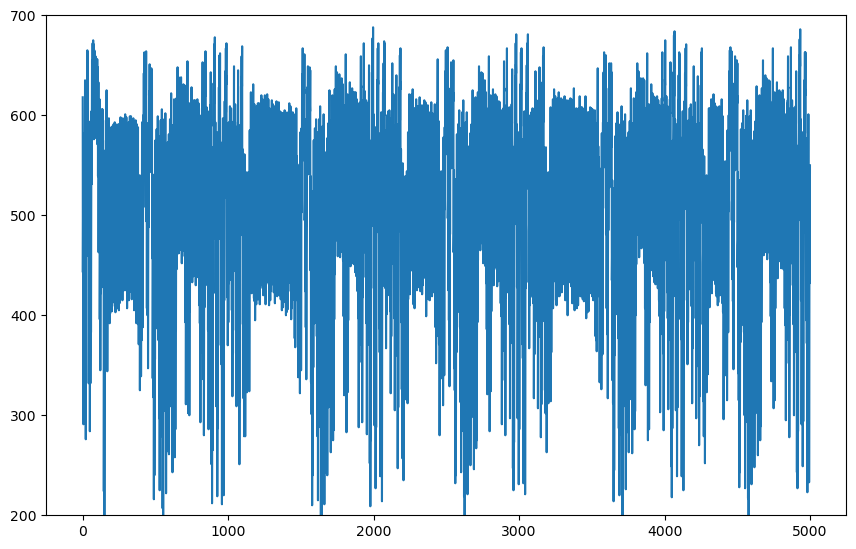

In [13]:
fig = plt.figure(1,(8.0, 5.0))

ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
ax.set_ylim(200.0, 700.0)

ax.plot(np.arange(5000), train_traces[99000])

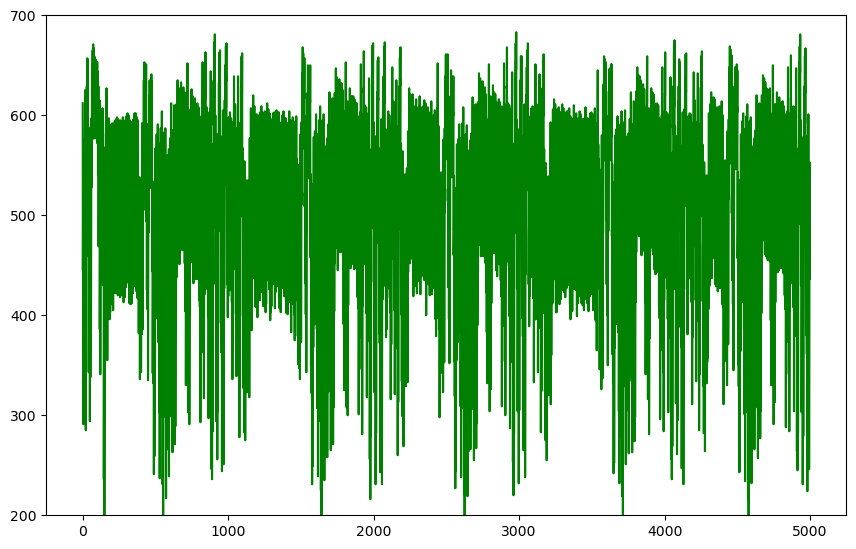

In [14]:
fig = plt.figure(1,(8.0, 5.0))
ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
ax.set_ylim(200.0, 700.0)

ax.plot(np.arange(5000), val_test_traces[450,4], color='green')

In [15]:
train_traces_trunc = train_traces[..., :1000]
val_test_traces_trunc = val_test_traces[..., :1000]

print(train_traces_trunc.shape)
print(val_test_traces_trunc.shape)

torch.Size([500000, 1000])
torch.Size([1000, 500, 1000])


In [16]:
train_traces_mean = train_traces_trunc.mean()
train_traces_std = train_traces_trunc.std()

In [17]:
train_traces_norm = (train_traces_trunc - train_traces_mean) / train_traces_std
val_test_traces_norm = (val_test_traces_trunc - train_traces_mean) / train_traces_std

## Dataset

In [18]:
class TrainingTraceSet(Dataset):
    def __init__(self, traces : torch.Tensor, keys, subkey_idx):

        self.traces = traces
        self.keys = keys[..., subkey_idx]

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        sample = self.traces[idx]
        target = self.keys[idx]
        return (sample, target)

In [19]:
class TestingTraceSet(Dataset):
    def __init__(self, traces, keys, subkey_idx):

        self.traces = traces
        self.keys = keys[..., subkey_idx]

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx):
        # One sample, N traces
        traces = self.traces[idx]
        key = self.keys[..., idx]

        return (traces, key)

In [20]:
class SboxTestingTraceSet(Dataset):
    def __init__(self, traces, plaintexts, keys, subbyte_idx):

        self.traces = traces

        # Plaintext must be included to map possible sbox outpouts back to keys
        self.plaintexts = plaintexts[..., subbyte_idx]
        self.keys = keys[..., subbyte_idx].squeeze()

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx):
        # One sample, N traces, N plaintexts, single key
        traces = self.traces[idx]
        plaintexts = self.plaintexts[idx].squeeze()
        key = self.keys[idx]

        return (traces, plaintexts, key)

## Model

In [21]:
# Zhang2019
class CNN_ZHANG(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 64, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(64, 128, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(128, 256, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(256, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(512, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Flatten(),

            nn.Linear(10752, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            # Cross entropy expects raw logits
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output


In [22]:
# Zhang2019
class CNN_Hettwer(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 8, 8),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Conv1d(8, 16, 8),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Conv1d(16, 32, 8),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Conv1d(32, 64, 8),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Flatten(),

            nn.Linear(3520, 20),
            nn.ReLU(),
            nn.Linear(20, 256),
            # Cross entropy expects raw logits
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output

## Computing keyrank

In [23]:
def mean_keyrank2(model : nn.Module, test_loader : DataLoader):
    total_rank = 0
    
    for traces, key in tqdm(test_loader, 'computing keyrank'):

        traces = traces.to(device)
        key = key.to(device)

        output = model(traces.squeeze())

        _, rankings = torch.unique(-output, sorted=True, return_inverse=True, dim=-1)

        rankings = rankings.type(torch.float64)

        current_rank = (rankings * F.one_hot(key.long(), 256)).sum()

        # Multiply with one hot tensor to retain only rank of target class
        total_rank += current_rank


    mean_rank = total_rank / len(test_loader)

    return mean_rank


In [24]:
def mean_keyrank(model : nn.Module, test_loader : DataLoader):
    total_rank = 0

    for traces, key in tqdm(test_loader, 'computing keyrank', leave=False):

        traces = traces.to(device)
        key = key.to(device)

        output : torch.Tensor = model(traces.squeeze())

        ranks = output.argsort(dim=-1, descending=True).argsort(dim=-1)

        total_rank += ranks[..., int(key)].mean(dtype=float)

    mean_rank = total_rank / len(test_loader)

    return mean_rank

In [25]:
import keyrank_rs

def mean_sbox_rank(model : nn.Module, sbox_test_loader : DataLoader):
    
    total_rank = 0

    for traces, plaintexts, true_key in tqdm(sbox_test_loader, 'computing keyrank', leave=False):

        traces : torch.Tensor = traces.to(device)
        plaintexts : torch.Tensor = plaintexts.squeeze().to(device)


        sbox_scores : torch.Tensor = model(traces.squeeze())

        keyscores = torch.empty(sbox_scores.shape)

        for idx, (sbox_score, plaintext) in enumerate(zip(sbox_scores, plaintexts)):

            plaintext_int = plaintext.long().item()
            numpy_scores = sbox_score.detach().cpu().numpy()
            
            numpy_keyscores : np.array =  keyrank_rs.sbox_scores_to_key_scores(plaintext_int, numpy_scores)

            keyscores[idx] = torch.Tensor(numpy_keyscores).to(device)



        ranks = keyscores.argsort(dim=-1, descending=True).argsort(dim=-1)


        total_rank += ranks[..., int(true_key)].mean(dtype=float)

    mean_rank = total_rank / len(sbox_test_loader)

    return mean_rank


## Training

In [26]:
import os

def train_model(
        model : nn.Module,
        optimizer : optim.Optimizer,
        loss_fn,
        train_loader : DataLoader,
        val_loader : DataLoader,
        folder,
        n_epochs = 10,
        prediction_target = "key"
    ):

    os.makedirs(f"models/{folder}", exist_ok=True)

    train_losses = []
    val_ranks = []

    for epoch in range(n_epochs):

        model.train()

        train_loss = 0

        for input, target in tqdm(train_loader, 'training model', unit='batch', leave=False):

            target = target.type(torch.LongTensor)

            #target_onehot = F.one_hot(target, 256).to(device)



            # Move batch to GPU
            input = input.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            outputs = model(input)

            loss = loss_fn(outputs, target)

            loss.backward()

            optimizer.step()

            train_loss+=loss.item()



        train_loss /= len(train_loader)

        train_losses.append(train_loss / len(train_loader.dataset))


        # Validate
        model.eval()
        with torch.no_grad():
            if prediction_target == "key":
                val_mean_rank = mean_keyrank(model, val_loader)
            else:
                val_mean_rank = mean_sbox_rank(model, val_loader)
            
        val_ranks.append(val_mean_rank)

        torch.save(model, f"models/{folder}/epoch{epoch+1}.pt")
        
        print(f"Epoch #{epoch+1} of {n_epochs}, training loss: {train_loss:.3f}, val mean keyrank: {val_mean_rank:.3f}")

    return (train_losses, val_ranks)

In [27]:
EPOCHS = 100
BATCH_SIZE = 200
PREDICTION_TARGET = "key"

In [28]:
print(train_sbox_output.shape)
print(train_keys.shape)

print(val_test_sbox_output.shape)
print(val_test_keys.shape)

torch.Size([500000, 16])
torch.Size([500000, 16])
torch.Size([1000, 500, 16])
torch.Size([1000, 16])


In [29]:
# Dataset with sbox or key as target
if PREDICTION_TARGET == "key":
    train_set = TrainingTraceSet(train_traces_norm[:,:], train_keys, 0)
    val_test_set = TestingTraceSet(val_test_traces_norm, val_test_keys, 0)
else:
    train_set = TrainingTraceSet(train_traces_norm[:,:], train_sbox_output, 0)
    val_test_set = SboxTestingTraceSet(val_test_traces_norm, val_test_plaintexts, val_test_keys, 0)

val_set, test_set = random_split(val_test_set, [0.5, 0.5], generator = torch_rng)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, generator=torch_rng)
val_loader = DataLoader(val_set)
test_loader = DataLoader(test_set)

In [30]:
test = CNN_Hettwer().to(device)
pytorch_total_params = sum(p.numel() for p in test.parameters() if p.requires_grad)
print(pytorch_total_params)

97708


In [31]:
torch.manual_seed(676)
model = CNN_ZHANG().to(device)



In [32]:
# Zhang 2019
adam = optim.Adam(model.parameters(), lr=0.00001)

# Hettwer 2020, optimizer not specified
#adam = optim.Adam(model.parameters(), lr=0.001)
#sgd = optim.SGD(model.parameters(), lr=0.00001)

cross_entropy = nn.CrossEntropyLoss()

model.eval()
with torch.no_grad():
    validation_mean_keyrank = mean_keyrank(model, val_loader)

print(f"Mean keyrank before training: {validation_mean_keyrank}")

scores = train_model(
    model,
    adam,
    cross_entropy,
    train_loader,
    val_loader,
    "test",
    n_epochs=EPOCHS,
    prediction_target=PREDICTION_TARGET,
)

training model:   0%|          | 0/2500 [00:00<?, ?batch/s]         

Mean keyrank before training: 127.43174399999995


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #1 of 100, training loss: 5.545, val mean keyrank: 130.679


KeyboardInterrupt: 

In [ ]:
LOAD_EXPERIMENT = "fixslice-byte0-zhang2019"
LOAD_EPOCH = 50

model = torch.load(f"models/{LOAD_EXPERIMENT}/epoch{LOAD_EPOCH}.pt")

C:\Users\Ulrik\AppData\Local\Temp\ipykernel_12760\3359755357.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"models/{LOAD_EXPERIMENT}/epoch{LOAD_EPO

In [ ]:
testing_keyrank = mean_keyrank(model, test_loader)

In [ ]:
print(f"Mean keyrank: {testing_keyrank}")

Mean keyrank: 85.02445599999999


In [ ]:
testing_keyrank = mean_sbox_rank(model, test_loader)
print(f"Mean keyrank: {testing_keyrank}")

Mean keyrank: 84.49540800000001


## Gradient based saliency map

In [ ]:
grads = 0.

sgd = optim.SGD(model.parameters())

for traces, sbox in tqdm(val_loader, 'computing gradients'):

    traces : torch.Tensor = traces.to(device)

    # Set up gradient computation in computational graph
    traces.requires_grad = True
    traces.retain_grad()

    output = model(traces.squeeze())

    correct_idx = int(sbox)

    # Backward on magnitude sum of correct prediction
    output[correct_idx].sum().backward()

    grads += traces.grad\
        .squeeze()\
        .abs()\
        .mean(dim=0)


computing gradients: 100%|██████████| 500/500 [01:04<00:00,  7.79it/s]


tensor(908)


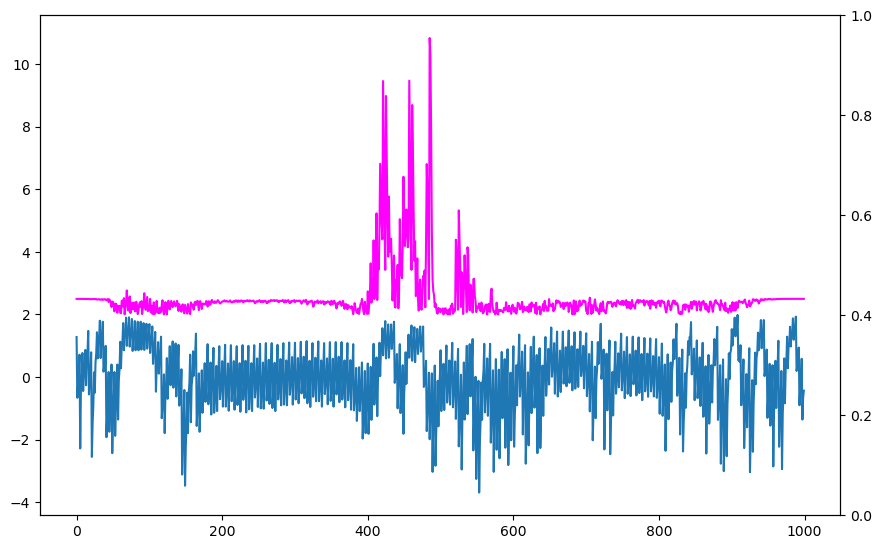

In [ ]:
fig = plt.figure(1,(8.0, 5.0))

ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
#ax.set_ylim(200.0, 700.0)

grads_mean = grads.cpu().mean()
grads_std =  grads.cpu().std()
grads_norm = (grads.cpu() - grads_mean) / grads_std

ax.plot(np.arange(1000), grads_norm.abs() + 2.0, color='magenta', alpha=1.0)

test_trace = val_test_traces[141][0][:1000]
test_trace_mean = test_trace.mean()
test_trace_std = test_trace.std()
test_trace_norm = (test_trace - test_trace_mean) / test_trace_std

ax2 = ax.twinx()
ax.plot(np.arange(1000), test_trace_norm)

print(test_trace.argmax())


## Occlusion based saliency map